In [1]:
# current ADAM resnet18 with 200 epochs is 76% accuracy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
from numpy import asarray
import PIL.Image as Image
import torch.nn as nn
import tqdm
import gc

device = "cuda"

torch.cuda.empty_cache()
gc.collect()
        
import torchvision.transforms as transforms
transform = transforms.ToTensor()

In [2]:
patch_size = 16

# get dataset stuffs
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.utils import load_state_dict_from_url

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

dataset = torchvision.datasets.CIFAR100(root="based", train=False, download=True, transform=transform)

val_dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


dataset = torchvision.datasets.CIFAR100(root="based", train=True, download=True, transform=transform)

train_dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

0it [00:00, ?it/s]

Extracting based/cifar-100-python.tar.gz to based
Files already downloaded and verified


In [3]:
!pip install vit-pytorch

In [4]:
def testb():
    acc = 0
    total = 0
    for n_, (x, y) in enumerate(val_dataloader):
        x = x.to(device)
        bs = x.shape[0]
        x = x.reshape(bs, 3, 32, 32)
        
        y_hat = v(x) # add encodings?
        for _, i in enumerate(y_hat):
            if i.argmax() == y.to(device)[_]:
                acc +=1
            total +=1
            
    return acc/total

In [5]:

import torch
from vit_pytorch import ViT

# get ViT-B/16 model
"""
# ViT-L/8
v = ViT(
    image_size = 32,
    patch_size = 8,
    num_classes = 10,
    dim = 1024,
    depth = 24,
    heads = 16,
    mlp_dim = 4096,
    dropout = 0.1,
    emb_dropout = 0.1
)
"""
# ViT-L/24
v = ViT(
    image_size = 32,
    patch_size = patch_size,
    num_classes = 100,
    dim = 1024,
    depth = 24,
    heads = 16,
    mlp_dim = 4096,
    dropout = 0.1,
    emb_dropout = 0.1
)

#from pytorch_pretrained_vit import ViT
#v = ViT('B_16_imagenet1k', pretrained=True)

v.eval()

# initialize stuffs
losslist_n = []
v = v.to(device)
voptimizer = torch.optim.Adam(v.parameters(), lr=.0001)
import random
import time

timelist_n = []
acc = 0
total = 0
# do loop for baseline
stime = time.time()
for epoch in range(150):
    t = tqdm.tqdm(train_dataloader, position=0, leave=True)
    tloss = 0
    # loop over data
    n = 0
    for (x, y) in t:
        n +=1
        bs = x.shape[0]
        
        # change device to gpu
        x = x.to(device)
        y = y.to(device)
        
        # forward pass
        x = x.reshape(bs, 3, 32, 32)
        f_y_hat = v(x)
        
        # backward pass
        loss = torch.nn.CrossEntropyLoss()((f_y_hat).reshape([bs, 100]), y) # nn.ReLU()
        loss.backward()
        tloss += loss
        
        # optimize
        voptimizer.step() 
        voptimizer.zero_grad()
        
        # keep track of this epoch's loss
        t.set_description_str(str(tloss.detach().cpu().numpy()/(n+1))) # 14:.2
        
    # test epoch's accuracy and append it to the list
    l = testb()
    print(l)
    losslist_n.append(l)
    timelist_n.append(time.time() - stime)
    
# 5 = 2 normal
# new 1.8 = 5

4.155311545744765: 100%|██████████| 196/196 [01:41<00:00,  1.93it/s]


0.1125


3.6842177337801396: 100%|██████████| 196/196 [01:42<00:00,  1.92it/s]


0.1571


3.472987141100888: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.1903


3.3061371624167197: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.2109


3.176285332229537: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.228


3.0678624187024113: 100%|██████████| 196/196 [01:42<00:00,  1.90it/s]


0.2387


2.9676445510786804: 100%|██████████| 196/196 [01:42<00:00,  1.90it/s]


0.2612


2.8741854749960343: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.2694


2.776958020205425: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.2835


2.6822931125079315: 100%|██████████| 196/196 [01:42<00:00,  1.90it/s]


0.2859


2.5827850496708438: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3017


2.483448938669892: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3096


2.364579099083915: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3185


2.232457969394432: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3204


2.0986140682007455: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3297


1.9488172192258884: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3309


1.765450724490403: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3278


1.5717159987706217: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3326


1.3569572952193052: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3379


1.1372104393044098: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3389


0.9165489080593671: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3409


0.7165248502934645: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3387


0.564767208196185: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.334


0.4419539398348271: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3429


0.3732567414414459: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]


0.3437


0.31798752915435635: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3393


0.2718376508218988: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3364


0.24529787247556115: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3377


0.2293221526944698: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3381


0.1980197732218631: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3439


0.1968366167872085: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.341


0.18270471253370876: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3435


0.17655123792929092: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3317


0.16278699690920448: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3375


0.16043126643611694: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3349


0.1583452079501854: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3372


0.14854547336016816: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.336


0.13899737324206357: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3346


0.13747284013002656: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3371


0.13271314359558414: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3317


0.13046743906088892: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3368


0.12740141002054747: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.335


0.11369010034551476: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.3393


0.11757107071465042: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3303


0.11452255636302348: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.3343


0.11774721484498929: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.3354


0.11696121293276095: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3332


0.11515639639142806: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3329


0.11120673242559288: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3312


0.1003796727524191: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3293


0.09981755677818648: 100%|██████████| 196/196 [01:42<00:00,  1.90it/s]


0.3295


0.09970291253878985: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3315


0.09603136324035334: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3379


0.09405478850233978: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.33


0.09525301008660177: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3372


0.08874255146471982: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.3286


0.08958134917438333: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3262


0.10047838046466033: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3315


0.08672382141732927: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3326


0.08058241055096467: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3345


0.08495421821090776: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3262


0.08095985257686092: 100%|██████████| 196/196 [01:45<00:00,  1.85it/s]


0.3346


0.0859229770408669: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3333


0.09326519457821919: 100%|██████████| 196/196 [01:45<00:00,  1.85it/s]


0.332


0.09121592758875813: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.329


0.07529970837123504: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3354


0.08038829667919178: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3321


0.06841757817921905: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3332


0.07469113829172203: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3375


0.07669107078900797: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3329


0.07964365615457447: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3295


0.0762921008966901: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3347


0.07961427136726186: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3314


0.06655782128348568: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3309


0.06579796553868328: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3338


0.07265933758111169: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3406


0.06434232934477366: 100%|██████████| 196/196 [01:45<00:00,  1.85it/s]


0.3357


0.05758088494315365: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3306


0.06616472834863034: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3357


0.07607434364744854: 100%|██████████| 196/196 [01:43<00:00,  1.88it/s]


0.3294


0.07609299112697543: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3316


0.06021801711339031: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3394


0.06280286663074784: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3362


0.06448541922012561: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.3332


0.06067417841877429: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3393


0.057964823572768776: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3327


0.06793873685265556: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3325


0.07062572150060974: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3362


0.061796541746497756: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3366


0.055759928553237526: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.3401


0.05605114777076063: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3345


0.06345104566080316: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3312


0.06358441483550871: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3401


0.06531607923168821: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3388


0.05003539438780189: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.3398


0.05904552537172579: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3385


0.05887031555175781: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3367


0.06170358028508685: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3318


0.05457890699357551: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3329


0.043747563047457465: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3417


0.05017362875381702: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3292


0.0492866922756137: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3298


0.055326132604918504: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3381


0.05313039189062748: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3325


0.05108714708822028: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3346


0.052863164601592245: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3378


0.057092656944003804: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3302


0.05088078552091182: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3331


0.05057701846669773: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3295


0.047758586515629954: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3351


0.04538261103751091: 100%|██████████| 196/196 [01:42<00:00,  1.90it/s]


0.3333


0.05223376859868238: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3291


0.050953308337836095: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3335


0.04676793190428448: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3279


0.05121796990409115: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3287


0.04865642973614223: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.333


0.04724298273851424: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3425


0.03966979932058886: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3347


0.039733772955570124: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3407


0.04702597584216123: 100%|██████████| 196/196 [01:43<00:00,  1.90it/s]


0.3328


0.05302807280254848: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3295


0.05752618179708568: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3368


0.04320488363353129: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3395


0.03675515518575755: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.339


0.03940705962592575: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.3364


0.038358504397009836: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3346


0.046650368550102114: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.337


0.042089568781973744: 100%|██████████| 196/196 [01:45<00:00,  1.87it/s]


0.3361


0.046197087631612864: 100%|██████████| 196/196 [01:44<00:00,  1.88it/s]


0.3376


0.04978813132658828: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.3373


0.045424422636855075: 100%|██████████| 196/196 [01:45<00:00,  1.87it/s]


0.3339


0.041978502031510254: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3377


0.04408192029459222: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3317


0.04295746566075359: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.3335


0.041891543393207685: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3354


0.042666004393911605: 100%|██████████| 196/196 [01:46<00:00,  1.84it/s]


0.3339


0.03970018619208166: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3414


0.036316080141793654: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.3405


0.04012615668592114: 100%|██████████| 196/196 [01:43<00:00,  1.89it/s]


0.336


0.03630250843648378: 100%|██████████| 196/196 [01:45<00:00,  1.87it/s]


0.3417


0.044379142335223665: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3351


0.03848569405260425: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3399


0.03340214521146668: 100%|██████████| 196/196 [01:42<00:00,  1.92it/s]


0.3379


0.03652818311894605: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3372


0.044150018449967285: 100%|██████████| 196/196 [01:44<00:00,  1.87it/s]


0.3364


0.04650108705317309: 100%|██████████| 196/196 [01:45<00:00,  1.87it/s]


0.3353


0.04401251023190881: 100%|██████████| 196/196 [01:42<00:00,  1.91it/s]


0.3361


0.04781727863447315: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.335


0.04050216335935641: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3428


0.03583953102228: 100%|██████████| 196/196 [01:45<00:00,  1.86it/s]


0.3366


In [6]:
# load in ViT-b/16 results from the above code ran in previous version, I seperated these two in case the session was terminated and the data would be lost
#losslist_n = [0.3157, 0.3891, 0.439, 0.4689, 0.477, 0.4756, 0.5138, 0.5237, 0.5193, 0.5305, 0.5254, 0.5387, 0.538, 0.5333, 0.5338, 0.537, 0.5315, 0.5291, 0.5326, 0.5311, 0.5343, 0.5281, 0.5314, 0.5348, 0.5386, 0.5441, 0.5356, 0.5313, 0.5389, 0.5413, 0.5356, 0.5364, 0.5333, 0.5355, 0.5315, 0.5379, 0.532, 0.535, 0.5357, 0.5372, 0.5377, 0.5473, 0.5449, 0.5476, 0.537, 0.54, 0.5382, 0.5447, 0.5443, 0.5383, 0.5358, 0.5437, 0.5411, 0.5445, 0.5457, 0.5427, 0.5417, 0.5376, 0.5367, 0.5335, 0.5391, 0.5463, 0.5426, 0.5446, 0.5442, 0.5437, 0.5425, 0.5407, 0.5454, 0.5453, 0.5496, 0.5428, 0.544, 0.5299, 0.5423, 0.5399, 0.5405, 0.5388, 0.5386, 0.5387, 0.5513, 0.545, 0.5419, 0.537, 0.5384, 0.5405, 0.5462, 0.5379, 0.5495, 0.55, 0.5417, 0.5526, 0.5459, 0.5427, 0.5366, 0.5468, 0.5494, 0.5487, 0.5459, 0.5411, 0.5495, 0.5474, 0.5455, 0.5498, 0.5476, 0.5476, 0.5509, 0.5454, 0.5459, 0.539, 0.545, 0.5509, 0.5467, 0.5453, 0.5409, 0.5493, 0.5422, 0.5379, 0.5439, 0.5438, 0.5488, 0.5497, 0.545, 0.5481, 0.5501, 0.5567, 0.5476, 0.5431, 0.5437, 0.5458, 0.5469, 0.5469, 0.5483, 0.5442, 0.5466, 0.5471, 0.5525, 0.546, 0.5458, 0.5472, 0.5459, 0.5471, 0.5432, 0.5493, 0.5521, 0.5455, 0.5441, 0.5422, 0.5487, 0.5507, 0.5461, 0.5522, 0.5425, 0.5502, 0.5555, 0.5563, 0.5524, 0.5537, 0.5462, 0.5571, 0.5475, 0.5464, 0.548, 0.5335, 0.5488, 0.5503, 0.5507, 0.5481, 0.5403, 0.5444, 0.5473, 0.5435, 0.5491, 0.5421, 0.5532, 0.5531, 0.5546, 0.5551, 0.5534, 0.5484, 0.5433, 0.5558, 0.5452, 0.5509, 0.5482, 0.5452, 0.5556, 0.5527, 0.5511, 0.5469, 0.5474, 0.549, 0.547, 0.5456, 0.5508, 0.5471, 0.5571, 0.5499, 0.554, 0.5525]
print(losslist_n)
print(timelist_n)

torch.save(v.state_dict(), "v")
torch.save(voptimizer.state_dict(), "o")
#torch.save(Head.state_dict(), "H")

[0.1125, 0.1571, 0.1903, 0.2109, 0.228, 0.2387, 0.2612, 0.2694, 0.2835, 0.2859, 0.3017, 0.3096, 0.3185, 0.3204, 0.3297, 0.3309, 0.3278, 0.3326, 0.3379, 0.3389, 0.3409, 0.3387, 0.334, 0.3429, 0.3437, 0.3393, 0.3364, 0.3377, 0.3381, 0.3439, 0.341, 0.3435, 0.3317, 0.3375, 0.3349, 0.3372, 0.336, 0.3346, 0.3371, 0.3317, 0.3368, 0.335, 0.3393, 0.3303, 0.3343, 0.3354, 0.3332, 0.3329, 0.3312, 0.3293, 0.3295, 0.3315, 0.3379, 0.33, 0.3372, 0.3286, 0.3262, 0.3315, 0.3326, 0.3345, 0.3262, 0.3346, 0.3333, 0.332, 0.329, 0.3354, 0.3321, 0.3332, 0.3375, 0.3329, 0.3295, 0.3347, 0.3314, 0.3309, 0.3338, 0.3406, 0.3357, 0.3306, 0.3357, 0.3294, 0.3316, 0.3394, 0.3362, 0.3332, 0.3393, 0.3327, 0.3325, 0.3362, 0.3366, 0.3401, 0.3345, 0.3312, 0.3401, 0.3388, 0.3398, 0.3385, 0.3367, 0.3318, 0.3329, 0.3417, 0.3292, 0.3298, 0.3381, 0.3325, 0.3346, 0.3378, 0.3302, 0.3331, 0.3295, 0.3351, 0.3333, 0.3291, 0.3335, 0.3279, 0.3287, 0.333, 0.3425, 0.3347, 0.3407, 0.3328, 0.3295, 0.3368, 0.3395, 0.339, 0.3364, 0.3346, 0.

In [7]:
def test(f):
    acc = 0
    total = 0
    # loop over test set
    for n_, (x, y) in enumerate(val_dataloader):
        bs = x.shape[0]
        x = x.to(device)
        
        # f is how many times ViT loops over data
        for i in range(f):
            x = v(x)
            x = x.reshape(bs, 3, 32, 32)
            
        # apply Head
        y_hat = Head(x)
        
        # loop over predicted and see if equal to the ground truth
        for _, i in enumerate(y_hat):
            if i.argmax() == y.to(device)[_]:
                acc +=1
            total +=1
            
    return acc/total

In [8]:
# blank module to replace nn.Softmaxes with
class make_linear(torch.nn.Module):
    def __init__(self):
        super(make_linear, self).__init__()

    def forward(self, x):
        return x

In [9]:
def replace_layers(model, old, new):
    # stolen from stack overflow, replaces all non linearities so that transformers are linear
    for n, module in model.named_children():
        if len(list(module.children())) > 0:
            ## compound module, go inside it
            replace_layers(module, old, new)
            
        if isinstance(module, old):
            ## simple module
            setattr(model, n, new)

In [10]:
import torch
from vit_pytorch import ViT

v = ViT(
    image_size = 32,
    patch_size = 16,
    num_classes = 10,
    dim = 768,
    depth = 24,
    heads = 16,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1
)

#from pytorch_pretrained_vit import ViT
#model = ViT('B_16_imagenet1k', pretrained=True)

v.eval()
v = torch.nn.Sequential(*(list(v.children())[:-1])) # get rid of MLP dim
# MLP dim consists of Layernorm and then activationless FC
v = torch.nn.Sequential(*(list(v.children()) + [nn.BatchNorm1d(4)])) #
#replace_layers(v, nn.Softmax, make_linear())

losslist_r = []

#Head = torch.nn.Sequential(*(list([ViT(image_size=32, patch_size=32, num_classes=10, dim=768, depth=1, heads=4, mlp_dim=3072)]))) # might want to increase head size bc the ViT is just interpresting patterns this actually makes decision
Head = torch.nn.Sequential(*(list([nn.Flatten(), nn.LayerNorm(3072), nn.Linear(3072, 100)])))


v = v.to(device)
Head = Head.to(device)

voptimizer = torch.optim.Adam(v.parameters(), lr=.0001)
hoptimizer = torch.optim.Adam(Head.parameters(), lr=.0001)
import random
import time

timelist_r = []

loops = 2 # might need to reward not having vanishing things, right now problem is prob that numbers get smaller and smaller - actually use Batch norm

acc = 0
total = 0
stime = time.time()
for epoch in range(150):
    t = tqdm.tqdm(train_dataloader, position=0, leave=True)
    tloss = 0

    for n, (x, y) in enumerate(t):
        bs = x.shape[0]
        x = x.to(device)
        #print(x.shape)
        y = y.to(device)
        
        for i in range(loops):
            
            x = v(x)
            x = x.reshape(bs, 3, 32, 32)
            #print(x[0][0][0])
            #print(x.shape)

        f_y_hat = Head(x)
        
        loss = torch.nn.CrossEntropyLoss()((f_y_hat).reshape([bs, 100]), y) # nn.ReLU()
        loss.backward()
        tloss += loss

        hoptimizer.step() 
        hoptimizer.zero_grad()
        voptimizer.step() 
        voptimizer.zero_grad()
        
        t.set_description_str(str(tloss.detach().cpu().numpy()/(n+1))) # 14:.2
    l = test(loops)
    print(l)
    losslist_r.append(l)
    timelist_r.append(time.time() - stime)
        
# do hyperparam search on heads, depth and how many times to recurse

4.130409707828444: 100%|██████████| 196/196 [01:22<00:00,  2.36it/s]


0.0971


3.791471831652583: 100%|██████████| 196/196 [01:26<00:00,  2.26it/s]


0.1328


3.6102774483816966: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.1478


3.4647406753228633: 100%|██████████| 196/196 [01:27<00:00,  2.25it/s]


0.1765


3.348066991689254: 100%|██████████| 196/196 [01:26<00:00,  2.26it/s]


0.2073


3.2394465232382017: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.2138


3.161272944236288: 100%|██████████| 196/196 [01:27<00:00,  2.25it/s]


0.2303


3.069431849888393: 100%|██████████| 196/196 [01:23<00:00,  2.34it/s]


0.2431


2.98853722397162: 100%|██████████| 196/196 [01:24<00:00,  2.32it/s]


0.2522


2.910562632035236: 100%|██████████| 196/196 [01:27<00:00,  2.25it/s]


0.2616


2.8324893250757333: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.2733


2.7621674829599807: 100%|██████████| 196/196 [01:27<00:00,  2.25it/s]


0.2856


2.6815970284598216: 100%|██████████| 196/196 [01:26<00:00,  2.27it/s]


0.2914


2.5997769102758292: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.3037


2.5227010298748405: 100%|██████████| 196/196 [01:27<00:00,  2.24it/s]


0.3092


2.438324753119021: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.3127


2.345831423389668: 100%|██████████| 196/196 [01:27<00:00,  2.23it/s]


0.3087


2.254402783452248: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.3259


2.1465019693180007: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.3344


2.0493509720782845: 100%|██████████| 196/196 [01:27<00:00,  2.25it/s]


0.3407


1.936297202596859: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3381


1.8158250146982622: 100%|██████████| 196/196 [01:21<00:00,  2.39it/s]


0.3436


1.6881067704181283: 100%|██████████| 196/196 [01:27<00:00,  2.25it/s]


0.348


1.5473338535853796: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.3427


1.4107094589544802: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3417


1.2695561623086735: 100%|██████████| 196/196 [01:27<00:00,  2.24it/s]


0.3483


1.1128332955496651: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.341


0.9650702963069994: 100%|██████████| 196/196 [01:21<00:00,  2.39it/s]


0.3498


0.8193554780921157: 100%|██████████| 196/196 [01:27<00:00,  2.24it/s]


0.3457


0.6730470462721221: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3464


0.568391177119041: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3433


0.47901134101711973: 100%|██████████| 196/196 [01:27<00:00,  2.25it/s]


0.3521


0.4078450884137835: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3525


0.3482934212198063: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3521


0.3070796655148876: 100%|██████████| 196/196 [01:27<00:00,  2.24it/s]


0.3514


0.2569919702958088: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3471


0.25173650469098774: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3453


0.22542529203453843: 100%|██████████| 196/196 [01:27<00:00,  2.23it/s]


0.3497


0.22117283879494182: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.3466


0.2087668010166713: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3441


0.19891845936677893: 100%|██████████| 196/196 [01:28<00:00,  2.22it/s]


0.3494


0.18073208478032327: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.3468


0.16818692732830437: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.3482


0.16196324873943718: 100%|██████████| 196/196 [01:28<00:00,  2.22it/s]


0.3445


0.1605041756921885: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3451


0.1695541459686902: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3373


0.15380132441618005: 100%|██████████| 196/196 [01:28<00:00,  2.22it/s]


0.3438


0.14364604560696348: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3465


0.13334386202753806: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3422


0.14836139095072842: 100%|██████████| 196/196 [01:28<00:00,  2.22it/s]


0.3463


0.15306102013101383: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3412


0.13825174253814074: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.3479


0.12469245949570014: 100%|██████████| 196/196 [01:28<00:00,  2.22it/s]


0.3438


0.13243184770856584: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3397


0.1294647333573322: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3373


0.13565326223568042: 100%|██████████| 196/196 [01:28<00:00,  2.22it/s]


0.3393


0.11601987177011919: 100%|██████████| 196/196 [01:21<00:00,  2.39it/s]


0.3423


0.11423849572940749: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.341


0.12152392523629325: 100%|██████████| 196/196 [01:28<00:00,  2.21it/s]


0.3442


0.11127443702853455: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3414


0.10725175117959782: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.346


0.10673828514254823: 100%|██████████| 196/196 [01:28<00:00,  2.23it/s]


0.3427


0.0976759754881567: 100%|██████████| 196/196 [01:21<00:00,  2.39it/s]


0.3383


0.10913893641257773: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.3377


0.1149159742861378: 100%|██████████| 196/196 [01:28<00:00,  2.22it/s]


0.3367


0.10428440327547034: 100%|██████████| 196/196 [01:22<00:00,  2.36it/s]


0.3387


0.0953789827774982: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.3432


0.09118930660948461: 100%|██████████| 196/196 [01:29<00:00,  2.19it/s]


0.3348


0.10713086809430804: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.3378


0.10078655943578603: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.3388


0.09390674318586077: 100%|██████████| 196/196 [01:28<00:00,  2.22it/s]


0.3422


0.08969054903302874: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3443


0.10455335889543806: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.3353


0.08803051345202388: 100%|██████████| 196/196 [01:26<00:00,  2.26it/s]


0.3381


0.09204660143171038: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3415


0.08916303089686803: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.3413


0.07586109394929846: 100%|██████████| 196/196 [01:26<00:00,  2.26it/s]


0.3462


0.08357046088393853: 100%|██████████| 196/196 [01:23<00:00,  2.34it/s]


0.3392


0.0865631492770448: 100%|██████████| 196/196 [01:21<00:00,  2.39it/s]


0.3424


0.08879261600727938: 100%|██████████| 196/196 [01:24<00:00,  2.31it/s]


0.3397


0.08891414136302714: 100%|██████████| 196/196 [01:24<00:00,  2.31it/s]


0.3447


0.08413140627802634: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3365


0.08894418210399394: 100%|██████████| 196/196 [01:23<00:00,  2.34it/s]


0.344


0.0704047679901123: 100%|██████████| 196/196 [01:27<00:00,  2.25it/s]


0.3374


0.07763237855872329: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3362


0.08320952434929049: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3392


0.07913710633102729: 100%|██████████| 196/196 [01:30<00:00,  2.18it/s]


0.3337


0.07589930417586346: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3405


0.08809974242229851: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.3363


0.07963639376114826: 100%|██████████| 196/196 [01:29<00:00,  2.18it/s]


0.3338


0.07180936969056421: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3407


0.06860621608033472: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3448


0.06854315679900501: 100%|██████████| 196/196 [01:29<00:00,  2.19it/s]


0.34


0.06951052315381108: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3436


0.06306605436363999: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3439


0.07351842218515825: 100%|██████████| 196/196 [01:30<00:00,  2.17it/s]


0.3394


0.07312405352689783: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3302


0.07636764584755411: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3408


0.07073164959343112: 100%|██████████| 196/196 [01:29<00:00,  2.18it/s]


0.3348


0.064692565373012: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.3351


0.06631890608339894: 100%|██████████| 196/196 [01:22<00:00,  2.36it/s]


0.3389


0.06495633903814822: 100%|██████████| 196/196 [01:28<00:00,  2.21it/s]


0.3394


0.06734891813628528: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.3394


0.06660817593944315: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s]


0.3388


0.06522959105822505: 100%|██████████| 196/196 [01:26<00:00,  2.28it/s]


0.3399


0.06418125970023018: 100%|██████████| 196/196 [01:23<00:00,  2.34it/s]


0.3375


0.08233302953291913: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s]


0.3367


0.06906855836206553: 100%|██████████| 196/196 [01:24<00:00,  2.33it/s]


0.3367


0.05911091882355359: 100%|██████████| 196/196 [01:26<00:00,  2.27it/s]


0.3393


0.056518228686585716: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3396


0.058696002376322845: 100%|██████████| 196/196 [01:23<00:00,  2.35it/s]


0.34


0.06563067436218262: 100%|██████████| 196/196 [01:30<00:00,  2.16it/s]


0.3414


0.058912783252949616: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.3456


0.058396645954677036: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3384


0.06305135999407087: 100%|██████████| 196/196 [01:30<00:00,  2.16it/s]


0.3323


0.05888079137218242: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.3424


0.07082189345846371: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.3371


0.06780871079892528: 100%|██████████| 196/196 [01:30<00:00,  2.16it/s]


0.3433


0.05429901395525251: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.3386


0.06632891479803592: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.3365


0.05932721313165159: 100%|██████████| 196/196 [01:30<00:00,  2.17it/s]


0.3386


0.047086428622810206: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.3395


0.048081373681827466: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.3415


0.05167337826320103: 100%|██████████| 196/196 [01:28<00:00,  2.22it/s]


0.3426


0.0609740821682677: 100%|██████████| 196/196 [01:23<00:00,  2.36it/s]


0.3352


0.0782617306222721: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.3381


0.05965847385172941: 100%|██████████| 196/196 [01:25<00:00,  2.30it/s]


0.3394


0.05325158761472118: 100%|██████████| 196/196 [01:26<00:00,  2.26it/s]


0.3422


0.0483267355938347: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3392


0.04882494284182179: 100%|██████████| 196/196 [01:22<00:00,  2.36it/s]


0.3363


0.0532491888318743: 100%|██████████| 196/196 [01:29<00:00,  2.19it/s]


0.3369


0.05801853355096311: 100%|██████████| 196/196 [01:23<00:00,  2.36it/s]


0.3364


0.0485633879291768: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.3379


0.05083400862557547: 100%|██████████| 196/196 [01:30<00:00,  2.16it/s]


0.342


0.050706615253370634: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.3321


0.05574136850785236: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.3442


0.05557546323659469: 100%|██████████| 196/196 [01:30<00:00,  2.16it/s]


0.3395


0.05043277935105927: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s]


0.3304


0.0482866180186369: 100%|██████████| 196/196 [01:21<00:00,  2.40it/s]


0.3357


0.04957914352416992: 100%|██████████| 196/196 [01:30<00:00,  2.17it/s]


0.3386


0.054838224333159775: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3391


0.04936112676348005: 100%|██████████| 196/196 [01:22<00:00,  2.39it/s]


0.3399


0.045863253729684014: 100%|██████████| 196/196 [01:26<00:00,  2.26it/s]


0.3362


0.05042394813226194: 100%|██████████| 196/196 [01:24<00:00,  2.32it/s]


0.332


0.05455618975113849: 100%|██████████| 196/196 [01:21<00:00,  2.39it/s]


0.3386


0.05269825215242347: 100%|██████████| 196/196 [01:22<00:00,  2.37it/s]


0.3362


0.05156258174351284: 100%|██████████| 196/196 [01:27<00:00,  2.23it/s]


0.3292


0.054965822064146706: 100%|██████████| 196/196 [01:22<00:00,  2.38it/s]


0.3355


0.04728106090000698: 100%|██████████| 196/196 [01:21<00:00,  2.39it/s]


0.3358


0.053262511078192264: 100%|██████████| 196/196 [01:31<00:00,  2.15it/s]


0.3316


In [11]:
test(loops)

0.331

In [12]:
print(losslist_r)
print(timelist_r)

[0.0971, 0.1328, 0.1478, 0.1765, 0.2073, 0.2138, 0.2303, 0.2431, 0.2522, 0.2616, 0.2733, 0.2856, 0.2914, 0.3037, 0.3092, 0.3127, 0.3087, 0.3259, 0.3344, 0.3407, 0.3381, 0.3436, 0.348, 0.3427, 0.3417, 0.3483, 0.341, 0.3498, 0.3457, 0.3464, 0.3433, 0.3521, 0.3525, 0.3521, 0.3514, 0.3471, 0.3453, 0.3497, 0.3466, 0.3441, 0.3494, 0.3468, 0.3482, 0.3445, 0.3451, 0.3373, 0.3438, 0.3465, 0.3422, 0.3463, 0.3412, 0.3479, 0.3438, 0.3397, 0.3373, 0.3393, 0.3423, 0.341, 0.3442, 0.3414, 0.346, 0.3427, 0.3383, 0.3377, 0.3367, 0.3387, 0.3432, 0.3348, 0.3378, 0.3388, 0.3422, 0.3443, 0.3353, 0.3381, 0.3415, 0.3413, 0.3462, 0.3392, 0.3424, 0.3397, 0.3447, 0.3365, 0.344, 0.3374, 0.3362, 0.3392, 0.3337, 0.3405, 0.3363, 0.3338, 0.3407, 0.3448, 0.34, 0.3436, 0.3439, 0.3394, 0.3302, 0.3408, 0.3348, 0.3351, 0.3389, 0.3394, 0.3394, 0.3388, 0.3399, 0.3375, 0.3367, 0.3367, 0.3393, 0.3396, 0.34, 0.3414, 0.3456, 0.3384, 0.3323, 0.3424, 0.3371, 0.3433, 0.3386, 0.3365, 0.3386, 0.3395, 0.3415, 0.3426, 0.3352, 0.3381, 

In [13]:
torch.save(v.state_dict(), "vn")
torch.save(Head.state_dict(), "Hn")
torch.save(voptimizer.state_dict(), "on")
torch.save(hoptimizer.state_dict(), "ohn")

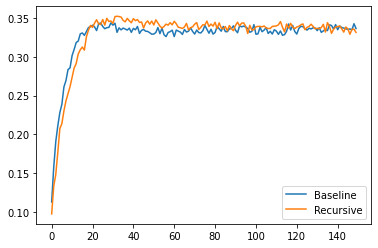

In [14]:
import matplotlib.pyplot as plt

plt.plot(list(range(len(losslist_n))), losslist_n, label="Baseline")
plt.plot(list(range(len(losslist_r))), losslist_r, label="Recursive")
plt.legend()
plt.show()

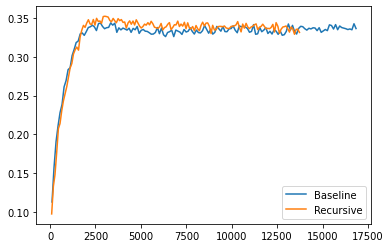

In [15]:
plt.plot(timelist_n, losslist_n, label="Baseline")
plt.plot(timelist_r, losslist_r, label="Recursive")
plt.legend()
plt.show()

In [16]:
print(max(losslist_n))
print(max(losslist_r))

0.3439
0.3525
